In [1]:
import os
import time
import random
import numpy as np

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.datasets import QM9
from torch_scatter import scatter

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#from google.colab import files
from IPython.display import HTML

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

PyTorch version 2.2.2
PyG version 2.0.3


In [2]:
#@title [RUN] Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(1)

In [3]:
# For storing experimental results over the course of the practical
RESULTS = {}

Convert networkx inputs to PyG

In [4]:
import json
import networkx as nx
import copy

def load_data_from_file(filename):
    """
    Load a dictionary of graphs from JSON file.
    """
    with open(filename, "r") as file_handle:
        string_dict = json.load(file_handle)
    return _load_data_from_string_dict(string_dict)

def load_data_from_string(json_string):
    """
    Load a dictionary of graphs from JSON string.
    """
    string_dict = json.loads(json_string)
    return _load_data_from_string_dict(string_dict)

def _load_data_from_string_dict(string_dict):
    result_dict = {}
    for key in string_dict:

        data = copy.deepcopy(string_dict[key])

        if 'edges' in data:
            data["links"] = data.pop("edges")

        graph = nx.node_link_graph(data)
        result_dict[key] = graph
    return result_dict

def write_data_to_json_string(graph_dict, **kwargs):
    """
    Write dictionary of graphs to JSON string.
    """
    json_string = json.dumps(graph_dict, default=nx.node_link_data, **kwargs)
    return json_string


def write_data_to_json_file(graph_dict, filename, **kwargs):
    """
    Write dictionary of graphs to JSON file.
    """
    with open(filename, "w") as file_handle:
        file_handle.write(write_data_to_json_string(graph_dict, **kwargs))

In [5]:
# dictionary of SMILES and values are graphs
train_data = load_data_from_file("../data/graphs/graph_data_duplicates.json") 

In [6]:
atom_dict = {
 'H':1, 'He':2, 'Li': 3, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'Ne': 10,
 'Na': 11, 'Mg': 12, 'Al': 13, 'Si': 14, 'P': 15, 'S': 16, 'Cl': 17, 'Ar': 18, 'K': 19, 'Ca': 20,
 'Ti': 22, 'V': 23, 'Cr': 24, 'Mn': 25, 'Fe': 26, 'Co': 27, 'Ni': 28, 'Cu': 29, 'Zn': 30,
 'Ga': 31, 'Ge': 32, 'As': 33, 'Se': 34, 'Br': 35, 'Kr': 36, 'Rb': 37, 'Sr': 38,
 'Mo': 42, 'Rh': 45, 'Ag': 47, 'Cd': 48, 'In': 49, 'Sn': 50,
 'Sb': 51, 'Te': 52, 'I': 53, 'Xe': 54, 'Cs': 55, 'Ba': 56,
 'W': 74, 'Re': 75, 'Hg': 80, 'Tl': 81, 'Pb': 82, 'Bi': 83, 'U': 92
}

orb_dict = {
 '1s': [1, 0, 0],
 '2s': [2, 0, 0],
 '2p': [2, 1, 0],
 '2p3/2': [2, 1, 1.5],
    
 '3s': [3, 0, 0],
 '3p': [3, 1, 0],
 '3p3/2': [3, 1, 1.5],
 '3d': [3, 2, 0],
 '3d5/2': [3, 2, 2.5],
    
 '4s': [4, 0, 0],
 '4p3/2': [4, 1, 1.5],
 '4d': [4, 2, 0],
 '4d5/2': [4, 2, 2.5],
 '4f7/2': [4, 3, 3.5],
    
 '5s': [5, 0, 0],
 '5p3/2': [5, 1, 1.5],
 '5d5/2': [5, 2, 2.5],
}

# Added bond categories following CoreIP team's data
bond_dict = {'NONE':0, 'SINGLE':1, 'DOUBLE':2, 'TRIPLE':3, 'QUADRUPLE':4,
             'DATIVE':5, 'AROMATIC':6}

In [7]:
import pandas as pd

# Lookup table for isolated binding energies
iso_be_df = pd.read_csv('../data/lookups/isolated_binding_energies.csv')

# SkipAtom embeddings (trained, 30 dimensions)
embed_df = pd.read_csv('../data/embeddings/embedding_dim30_induced.csv')

In [8]:
# Embedding IDs
embedded_atoms = list(embed_df['Atoms'])

# Embedding vectors
embed_dict = {}

for i in range(len(embed_df)):
    vec = np.fromstring(embed_df.loc[i,'Embeddings'].replace('\n','').strip('[]'), sep=' ')
    embed_dict[embedded_atoms[i]] = vec
        
# Embedding doesn't have entry for H
embed_dict['H'] = np.zeros(30)

In [9]:
dataset = []

for i, mol in enumerate(train_data):
    graph = train_data[mol]
    
    # Create node features (# atoms by target, atomic embedding, charge, one-hot encoding for orbital)
    targets = list(nx.get_node_attributes(graph, "pred").values())
    n_features = 1+1+30+1+3
    x = np.zeros((len(targets), n_features))

    # Indicate target atom
    atom_index = targets.index(True)
    x[atom_index, 0] = 1  
    
    # Indicate formal charges
    charge = list(nx.get_node_attributes(graph, "formal_charge").values())
    x[:, 1] = charge  
    
    # Indicate atom embeddings
    atom = list(nx.get_node_attributes(graph, "atom_type").values())
    embed_mat = np.array([embed_dict[a] for a in atom])
    x[:,2:32] = embed_mat
    
    # One hot encode orbital for target atom
    orb = list(nx.get_node_attributes(graph, "orbitals").values())
    x[atom_index, 32:35] = orb_dict[orb[atom_index][0]]
    
    # Electronegativity scores
    en_scores = list(nx.get_node_attributes(graph, "e_neg_score").values())
    en_flat = [en[0] for en in en_scores]
    x[:, 35] = en_flat      
    
    # Make PyG friendly
    x = torch.tensor(x, dtype=torch.float)
        
    # Target value
    energy = list(nx.get_node_attributes(graph, "binding_energies").values())
    y = torch.tensor([energy[atom_index][0]], dtype=torch.float)
    # Isolated binding energy from lookup table (for delta learning)
    be = float(iso_be_df.loc[atom_dict[atom[atom_index]]-1, orb[atom_index][0]]) 
    
    # Fix for edge_index with source and destination nodes
    edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()

    # Encode edge indices
    bond_types = list(nx.get_edge_attributes(graph, "bond_type").values())
    
    # Fix for edge_attr construction
    edge_attr = np.zeros((7, len(bond_types)))
    
    for j,b in enumerate(bond_types):
        edge_attr[bond_dict[b], j] = 1
    
    edge_attr = torch.tensor(edge_attr, dtype=torch.long).t().contiguous()

    # Then proceed with creating the Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y-be, 
                name=mol, orb=orb[atom_index][0], y0=be)
    dataset.append(data)

Data prep and splitting

In [10]:
from torch.utils.data import random_split

print(f"Total number of samples: {len(dataset)}.")

mols = np.array(list(train_data.keys()))
mols = np.array([mol.split('_')[0] for mol in mols]) # there are no underscores in the molecule names

# Get unique molecules and assign unique indices to each
unique_molecules, unique_index = np.unique(mols, return_inverse=True)

# Choose a random subset of test molecules
unseen_subset = np.random.choice(np.arange(0, 859), size=200, replace=False) # 100 random molecules

whitelist = ~np.in1d(unique_index, unseen_subset)
train_val_dataset = [dataset[i] for i in range(len(dataset)) if whitelist[i]]
test_dataset = [dataset[i] for i in range(len(dataset)) if not whitelist[i]] # Test dataset is the unseen subset

# Split datasets (our 3K subset)
# Split the dataset into train, validation, and test sets
train_size = int(0.75*len(train_val_dataset))
test_size = len(train_val_dataset)-train_size
split_seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, test_size], generator=split_seed)

print(f"Created dataset splits with {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples.")

# Create dataloaders with batch size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Total number of samples: 4250.
Created dataset splits with 2520 training, 840 validation, 890 test samples.


In [11]:
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=7, aggr='add'):
        """Message Passing Neural Network Layer

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # MLP `\psi` for computing messages `m_ij`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: (2d + d_e) -> d
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: 2d -> d
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

    def forward(self, h, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        As our MPNNLayer class inherits from the PyG MessagePassing parent class,
        we simply need to call the `propagate()` function which starts the
        message passing procedure: `message()` -> `aggregate()` -> `update()`.

        The MessagePassing class handles most of the logic for the implementation.
        To build custom GNNs, we only need to define our own `message()`,
        `aggregate()`, and `update()` functions (defined subsequently).

        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j, edge_attr):
        """Step (1) Message

        The `message()` function constructs messages from source nodes j
        to destination nodes i for each edge (i, j) in `edge_index`.

        The arguments can be a bit tricky to understand: `message()` can take
        any arguments that were initially passed to `propagate`. Additionally,
        we can differentiate destination nodes and source nodes by appending
        `_i` or `_j` to the variable name, e.g. for the node features `h`, we
        can use `h_i` and `h_j`.

        This part is critical to understand as the `message()` function
        constructs messages for each edge in the graph. The indexing of the
        original node features `h` (or other node variables) is handled under
        the hood by PyG.

        Args:
            h_i: (e, d) - destination node features
            h_j: (e, d) - source node features
            edge_attr: (e, d_e) - edge features

        Returns:
            msg: (e, d) - messages `m_ij` passed through MLP `\psi`
        """
        # SK - note how the dimensions of h_i and h_j were recast compared to forward()
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        return self.mlp_msg(msg)

    def aggregate(self, inputs, index, ptr=None, dim_size=None):

        """The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        aggr_out = scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce=self.aggr)

        return aggr_out

    def update(self, aggr_out, h):
        """
        Step (3) Update

        The `update()` function computes the final node features by combining the
        aggregated messages with the initial node features.

        `update()` takes the first argument `aggr_out`, the result of `aggregate()`,
        as well as any optional arguments that were initially passed to
        `propagate()`. E.g. in this case, we additionally pass `h`.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """

        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

In [12]:
class MPNNModel(Module):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=36, edge_dim=7, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()

        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)

        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))

        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)

    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns:
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)

        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

Unit tests

In [13]:
def permute_graph(data, perm):
    """Helper function for permuting PyG Data object attributes consistently.
    """
    # Permute the node attribute ordering
    data.x = data.x[perm]
    data.batch = data.batch[perm]

    # Permute the edge index
    adj = to_dense_adj(data.edge_index)
    adj = adj[:, perm, :]
    adj = adj[:, :, perm]
    data.edge_index = dense_to_sparse(adj)[0]

    # Note:
    # (1) While we originally defined the permutation matrix P as only having
    #     entries 0 and 1, its implementation via `perm` uses indexing into
    #     torch tensors, instead.
    # (2) It is cumbersome to permute the edge_attr, so we set it to constant
    #     dummy values. For any experiments beyond unit testing, all GNN models
    #     use the original edge_attr.

    return data

def permutation_invariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN model) is
    permutation invariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    out_1 = module(data)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    out_2 = module(data)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1, out_2, atol=1e-04)


def permutation_equivariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN layer) is
    permutation equivariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    out_1 = module(data.x, data.edge_index, data.edge_attr)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    out_2 = module(data.x, data.edge_index, data.edge_attr)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1[perm], out_2, atol=1e-04)

In [14]:
# Instantiate temporary model, layer, and dataloader for unit testing
layer = MPNNLayer(emb_dim=36, edge_dim=7)
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=36, edge_dim=7, out_dim=1)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Permutation invariance unit test for MPNN model
print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, dataloader)}!")

# Permutation equivariance unit for MPNN layer
print(f"Is {type(layer).__name__} permutation equivariant? --> {permutation_equivariance_unit_test(layer, dataloader)}!")

Is MPNNModel permutation invariant? --> True!
Is MPNNLayer permutation equivariant? --> True!


Training and evaluation

In [15]:
#@title [RUN] Helper functions for managing experiments, training, and evaluating models.

def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        
        # Standard MSE loss
        mse_loss = F.mse_loss(y_pred, data.y)

        # L2 regularization (weight decay)
        l2_lambda = 1e-3  # regularization strength
        l2_reg = sum((param**2).sum() for param in model.parameters())     
        
        loss = F.mse_loss(y_pred, data.y) + l2_lambda * l2_reg
        
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

    
def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            error += ((y_pred - data.y)**2).sum().item()
    return error / len(loader.dataset)


def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):
    
    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=1e-6)

    early_stopping_patience = 10
    epochs_since_improvement = 0
    best_val_error = np.inf
    best_test_error = None
    best_epoch = -1
    
    print("\nStart training:")
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)

        val_error = eval(model, val_loader, device)
        
        if val_error<best_val_error:
            best_val_error = val_error
            best_test_error = eval(model, test_loader, device)
            best_epoch = epoch
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                  f'Val MSE: {val_error:.7f}, Test MSE: {best_test_error:.7f}')

        scheduler.step(val_error)
        perf_per_epoch.append((best_test_error, val_error, epoch, model_name))

        if epochs_since_improvement >= early_stopping_patience:
            print(f"\nEarly stopping triggered at epoch {epoch}. "
                  f"No improvement in validation MSE for {early_stopping_patience} consecutive epochs.")
            break

    t = time.time() - t
    train_time = t/60
    print(f"\nDone! Training took {train_time:.2f} mins. Best validation MSE: {best_val_error:.7f}, corresponding test MSE: {best_test_error:.7f}.")

    return best_val_error, best_test_error, train_time, perf_per_epoch

In [16]:
model = MPNNModel(num_layers=5, emb_dim=64, in_dim=36, edge_dim=7, out_dim=1)
model_name = type(model).__name__


best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model,
    model_name,
    train_loader,
    val_loader,
    test_loader,
    n_epochs=100
)
RESULTS[model_name] = (best_val_error, test_error, train_time)

DF_RESULTS = pd.DataFrame(perf_per_epoch, columns=["Test MSE", "Val MSE", "Epoch", "Model"])

Running experiment for MPNNModel, training on 2520 samples for 100 epochs.

Model architecture:
MPNNModel(
  (lin_in): Linear(in_features=36, out_features=64, bias=True)
  (convs): ModuleList(
    (0-4): 5 x MPNNLayer(emb_dim=64, aggr=add)
  )
  (lin_pred): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 131393

Start training:
Epoch: 010, LR: 0.000100, Loss: 10.7075969, Val MSE: 24.7851132, Test MSE: 12.3845341
Epoch: 020, LR: 0.000100, Loss: 8.1779576, Val MSE: 24.9277723, Test MSE: 11.8513923
Epoch: 030, LR: 0.000090, Loss: 7.2011964, Val MSE: 24.7606335, Test MSE: 11.5208977
Epoch: 040, LR: 0.000081, Loss: 6.3788738, Val MSE: 24.3201856, Test MSE: 11.4784406

Early stopping triggered at epoch 46. No improvement in validation MSE for 10 consecutive epochs.

Done! Training took 1.65 mins. Best validation MSE: 23.8476040, corresponding test MSE: 11.4784406.


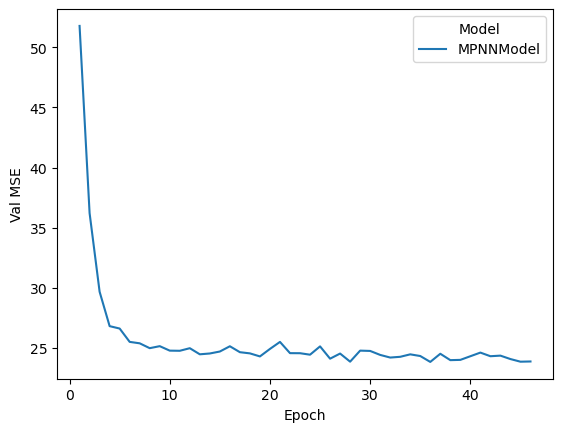

In [17]:
p = sns.lineplot(x="Epoch", y="Val MSE", hue="Model", data=DF_RESULTS)
#p.set(ylim=(0, 2));

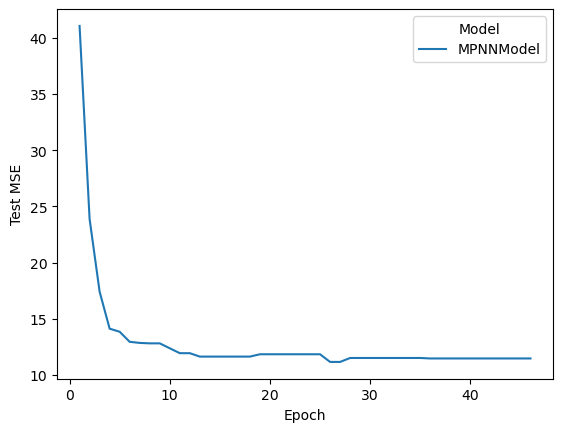

In [18]:
p = sns.lineplot(x="Epoch", y="Test MSE", hue="Model", data=DF_RESULTS)
#p.set(ylim=(0, 1));

Obtain predictions for training set

In [97]:
model.eval()

mol_name_list = []
orb_list = []
y_pred_list = []
y0_list = []
y_train_list = []


for data in train_loader:
    data = data.to('cpu')
    with torch.no_grad():
        y_pred = model(data)
        
        mol_name_list = mol_name_list + list(data.name)
        orb_list = orb_list + list(data.orb)
        y0_list += list(data.y0)
        y_pred_list = y_pred_list + list(y_pred+data.y0)
        y_train_list = y_train_list + list(data.y+data.y0)
        
y0_arr = np.array(y0_list)
y_pred_arr = np.array(y_pred_list)
y_train_arr = np.array(y_train_list)

In [98]:
np.mean(np.abs(y_pred_arr-y_train_arr))

0.7828511

In [99]:
np.mean(np.abs(y0_arr-y_train_arr))

6.2437468

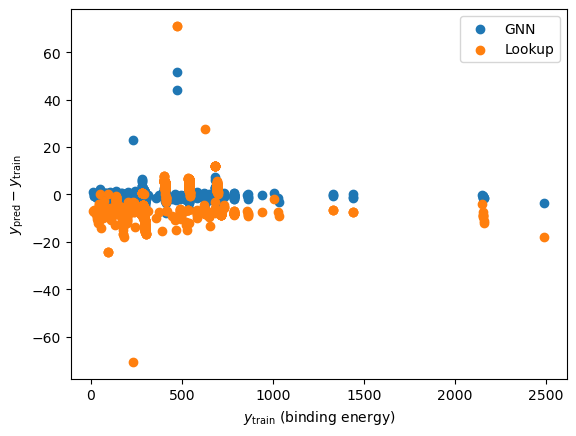

In [100]:
plt.scatter(y_train_arr, y_pred_arr-y_train_arr, label='GNN')
plt.scatter(y_train_arr, y0_arr-y_train_arr, label='Lookup')

plt.xlabel(r'$y_\mathrm{train}$ (binding energy)')
plt.ylabel(r'$y_\mathrm{pred}-y_\mathrm{train}$')

plt.legend()

Obtain top ten worst performance training molecules

In [101]:
mae_train = np.abs(y_pred_arr-y_train_arr)
train_idx = np.argsort(mae_train)[-1:-11:-1]

In [102]:
train_results = []

for idx in train_idx:
    
    train_results.append([mol_name_list[idx].split('_')[0], mol_name_list[idx].split('_')[1], 
          orb_list[idx], 
          y_train_arr[idx],
          y0_arr[idx],
          y_pred_arr[idx], mae_train[idx]])

In [103]:
train_df = pd.DataFrame(train_results, columns = ['mol', 'atom_idx', 'orb', 'y_true', 'y_lookup', 'y', 'mae'])

In [104]:
train_df

,mol,atom_idx,orb,y_true,y_lookup,y,mae
0,C1=CC(=O)N(C=C1)CCO,9,1s,471.950012,543.099976,523.477661,51.527649
1,C1=CC(=O)N(C=C1)CCO,3,1s,471.950012,543.099976,516.127014,44.177002
2,P(=S)(Cl)(Cl)Cl,1,2p3/2,233.199997,162.500000,256.398010,23.198013
3,[Cd],0,3d5/2,412.125000,405.200012,404.115143,8.009857
4,[O]1C(C(F)(F)F)=CC(C(F)(F)F)=[O][Cr+3]123([O-]...,37,1s,684.489990,696.700012,691.707458,7.217468
5,C->1:C->2:C->[Mn]12(C#[O+])(C#[O+])(C#[O+])(C#...,8,1s,283.470001,284.200012,289.792511,6.322510
6,CNC(=O)N(C)C,3,1s,536.700012,543.099976,530.501160,6.198853
7,[O]1C(C(F)(F)F)=CC(C(F)(F)F)=[O][Cr+3]123([O-]...,4,1s,684.489990,696.700012,690.530396,6.040405
8,C->1:C->2:C->[Mn]12(C#[O+])(C#[O+])(C#[O+])(C#...,4,1s,283.470001,284.200012,289.403046,5.933044
9,C->1:C->2:C->[Mn]12(C#[O+])(C#[O+])(C#[O+])(C#...,10,1s,283.470001,284.200012,289.179718,5.709717


Obtain predictions for validation set

In [105]:
model.eval()

mol_name_list = []
orb_list = []
y_pred_list = []
y0_list = []
y_val_list = []


for data in val_loader:
    data = data.to('cpu')
    with torch.no_grad():
        y_pred = model(data)
        
        mol_name_list = mol_name_list + list(data.name)
        orb_list = orb_list + list(data.orb)
        y0_list += list(data.y0)
        y_pred_list = y_pred_list + list(y_pred+data.y0)
        y_val_list = y_val_list + list(data.y+data.y0)
        
y0_arr = np.array(y0_list)
y_pred_arr = np.array(y_pred_list)
y_val_arr = np.array(y_val_list)

In [106]:
np.mean(np.abs(y_pred_arr-y_val_arr))

1.0947912

In [107]:
np.mean(np.abs(y0_arr-y_val_arr))

6.2004313

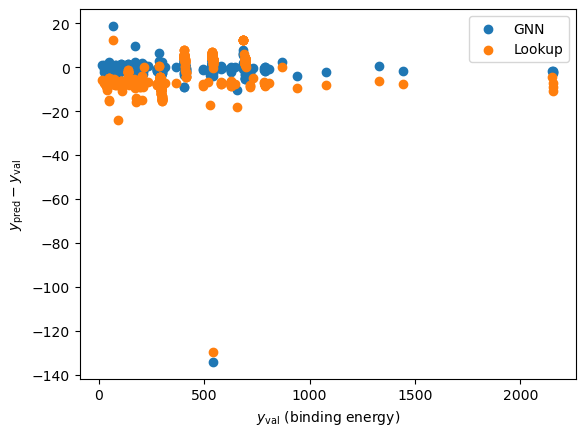

In [108]:
plt.scatter(y_val_arr, y_pred_arr-y_val_arr, label='GNN')
plt.scatter(y_val_arr, y0_arr-y_val_arr, label='Lookup')

plt.xlabel(r'$y_\mathrm{val}$ (binding energy)')
plt.ylabel(r'$y_\mathrm{pred}-y_\mathrm{val}$')

plt.legend()

Obtain top ten worst performance training molecules

In [109]:
mae_val = np.abs(y_pred_arr-y_val_arr)
val_idx = np.argsort(mae_val)[-1:-11:-1]

In [110]:
val_results = []

for idx in val_idx:
    
    val_results.append([mol_name_list[idx].split('_')[0], mol_name_list[idx].split('_')[1], 
          orb_list[idx], 
          y_val_arr[idx],
          y0_arr[idx],
          y_pred_arr[idx], mae_val[idx]])

In [111]:
val_df = pd.DataFrame(val_results, columns = ['mol', 'atom_idx', 'orb', 'y_true', 'y_lookup', 'y', 'mae'])

In [112]:
val_df

,mol,atom_idx,orb,y_true,y_lookup,y,mae
0,C1=CC(=O)N(C=C1)CCO,4,1s,539.580017,409.899994,405.344421,134.235596
1,[Cu]1234.CC(:O->1):C:C(:O->2)C.CC(:O->3):C:C(:...,0,3p,64.900002,77.300003,83.716164,18.816162
2,C->1:C->2:C->[Mn]12(C#[O+])(C#[O+])(C#[O+])C#[O+],3,2p3/2,656.799988,638.700012,646.594788,10.205200
3,FP(=S)(F)F,2,2p3/2,170.300003,162.500000,180.111389,9.811386
4,C1=CN=CC=C1N,6,1s,405.049988,409.899994,395.882812,9.167175
5,C1=CC=NC(=C1)N,6,1s,405.054993,409.899994,395.965179,9.089813
6,[O]1C(C(F)(F)F)=CC(C(F)(F)F)=[O][Cr+3]123([O-]...,38,1s,684.489990,696.700012,692.392578,7.902588
7,[O]1C(C(F)(F)F)=CC(C(F)(F)F)=[O][Cr+3]123([O-]...,36,1s,684.489990,696.700012,691.051514,6.561523
8,C->1:C->2:C->[Mn]12(C#[O+])(C#[O+])(C#[O+])(C#...,6,1s,283.470001,284.200012,289.917175,6.447174
9,[O]1C(C(F)(F)F)=CC(C(F)(F)F)=[O][Cr+3]123([O-]...,3,1s,684.489990,696.700012,690.456421,5.966431


Obtain predictions for test set

In [113]:
model.eval()

mol_name_list = []
orb_list = []
y_pred_list = []
y0_list = []
y_test_list = []


for data in test_loader:
    data = data.to('cpu')
    with torch.no_grad():
        y_pred = model(data)
        
        mol_name_list = mol_name_list + list(data.name)
        orb_list = orb_list + list(data.orb)
        y0_list += list(data.y0)
        y_pred_list = y_pred_list + list(y_pred+data.y0)
        y_test_list = y_test_list + list(data.y+data.y0)
        
y0_arr = np.array(y0_list)
y_pred_arr = np.array(y_pred_list)
y_test_arr = np.array(y_test_list)

In [114]:
np.mean(np.abs(y_pred_arr-y_test_arr))

1.2418205

In [115]:
np.mean(np.abs(y0_arr-y_test_arr))

6.231016

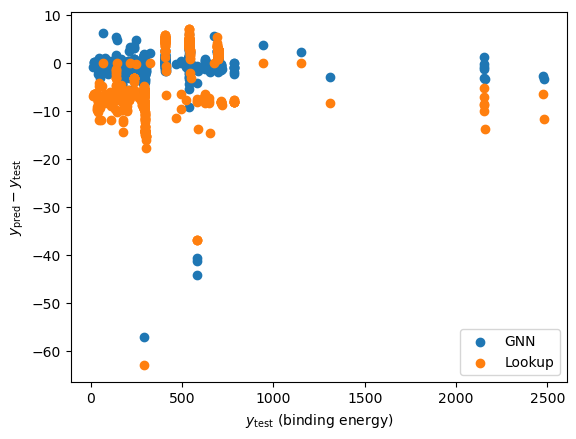

In [117]:
plt.scatter(y_test_arr, y_pred_arr-y_test_arr, label='GNN')
plt.scatter(y_test_arr, y0_arr-y_test_arr, label='Lookup')

plt.xlabel(r'$y_\mathrm{test}$ (binding energy)')
plt.ylabel(r'$y_\mathrm{pred}-y_\mathrm{test}$')

plt.legend()

Obtain top ten worst performance training molecules

In [118]:
mae_test = np.abs(y_pred_arr-y_test_arr)
test_idx = np.argsort(mae_test)[-1:-11:-1]

In [119]:
test_results = []

for idx in test_idx:
    
    test_results.append([mol_name_list[idx].split('_')[0], mol_name_list[idx].split('_')[1], 
          orb_list[idx], 
          y_test_arr[idx],
          y0_arr[idx],
          y_pred_arr[idx], mae_test[idx]])

In [120]:
test_df = pd.DataFrame(test_results, columns = ['mol', 'atom_idx', 'orb', 'y_true', 'y_lookup', 'y', 'mae'])

In [121]:
test_df

,mol,atom_idx,orb,y_true,y_lookup,y,mae
0,C[Mo]2345(C#[O+])(C#[O+])(C#[O+])<-C1=C->2C->3...,1,3d5/2,290.799988,227.899994,233.782776,57.017212
1,CC1(CC(OP(O1)OC)(C)C)C,4,1s,580.000000,543.099976,535.913635,44.086365
2,CC1(CC(OP(O1)OC)(C)C)C,6,1s,580.000000,543.099976,538.724304,41.275696
3,CC1(CC(OP(O1)OC)(C)C)C,7,1s,580.000000,543.099976,539.316589,40.683411
4,COC=1C(NC=CC1)=O,8,1s,538.909973,543.099976,529.668457,9.241516
5,[Xe],0,4d5/2,67.500000,67.500000,73.724922,6.224922
6,O([GeH3])[GeH3],0,1s,537.099976,543.099976,543.066345,5.966370
7,[O+]#C[Fe]12(C#[O+])(C#[O+])S[Fe]1(C#[O+])(C#[...,5,1s,293.160004,284.200012,287.283142,5.876862
8,O=[Mn](=O)(=O)Cl,4,2p3/2,207.449997,200.000000,201.657059,5.792938
9,[O+]#C[Fe]12(C#[O+])(C#[O+])S[Fe]1(C#[O+])(C#[...,3,1s,293.160004,284.200012,287.525940,5.634064
